# scGPT-based Single-Cell RNA-seq Immune Cell Annotation
## Overview

We applied the scGPT transformer-based model to single-cell RNA-seq data to classify and annotate immune cell types from blood samples. This approach leverages state-of-the-art deep learning for high-dimensional biological data, enabling robust identification of immune cell populations.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


------------------------------

# Environment Setup

------------------------------

In [ ]:
!pip install numpy==1.24.4

In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchtext==0.15.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2

In [ ]:
!pip install scanpy scvi-tools pandas matplotlib seaborn scipy numpy==1.24.4

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of treescope to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of treescope to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime

In [ ]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

------------------------------

# 1. Data Preprocessing
- Loaded raw single-cell RNA-seq count matrix.
- Performed quality control: filtered low-quality cells and genes.
- Normalized and log-transformed gene expression.
- Selected highly variable genes for downstream analysis.

------------------------------

In [ ]:
# Load the single-cell RNA-seq data
data_path = '/content/drive/MyDrive/UHN/rna_seq_data.txt'
df = pd.read_csv(data_path, sep='\t', index_col=0)
print(f"Data loaded: {df.shape[0]} cells, {df.shape[1]} genes")

Data loaded: 16345 cells, 20389 genes


In [ ]:
# Convert to AnnData object for Scanpy compatibility (transpose to have cells as rows, genes as columns)
adata = sc.AnnData(X=scipy.sparse.csr_matrix(df.T), obs=pd.DataFrame(index=df.columns), var=pd.DataFrame(index=df.index))
print("Converted to AnnData")

Converted to AnnData


In [ ]:
# Debug: Check gene names and cell barcodes
print("First 10 gene names:", adata.var_names[:10].tolist())
print("First 10 cell barcodes:", adata.obs_names[:10].tolist())

First 10 gene names: ['AL627309.5', 'HES4', 'ISG15', 'SMIM1', 'PLEKHG5', 'TNFRSF9', 'RBP7', 'KIF1B', 'AL021155.5', 'BX284668.6']
First 10 cell barcodes: ['AAACCTGAGCGTTTAC-1_1', 'AAACCTGAGCTGTCTA-1_1', 'AAACCTGCACCCATGG-1_1', 'AAACCTGGTAGGGACT-1_1', 'AAACCTGGTGGGTCAA-1_1', 'AAACCTGTCAGCTTAG-1_1', 'AAACCTGTCAGGCGAA-1_1', 'AAACGGGCAAGTAATG-1_1', 'AAACGGGCACATGGGA-1_1', 'AAACGGGGTCACACGC-1_1']


In [ ]:
# Basic QC
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
# Save for scGPT
adata.write('/content/drive/MyDrive/UHN/adata_scgpt.h5ad')

------------------------------

# 2. Embedding Extraction with scGPT
- Used the pre-trained whole_human scGPT checkpoint.
- Generated cell embeddings for all cells using the embed_data function.

------------------------------

### 2.1 Clone the scGPT Repository

In [ ]:
!!git clone https://github.com/bowang-lab/scGPT.git /content/scGPT
%cd /content/scGPT
!pip install -e .

/content/scGPT
Obtaining file:///content/scGPT
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for scGPT (pyproject.toml) ... done
  Created wheel for scGPT: filename=scgpt-0.2.4-py3-none-any.whl size=5572 sha256=9e221bca9e9dc7cefc7460112c6359484ef189ac4bc1cdf616f4c3fe5e806f26
  Stored in directory: /tmp/pip-ephem-wheel-cache-jh2y_qvm/wheels/04/7a/6e/e8aa378c203365c79eacc846f410dd65035eb47fec5bdccf92
Successfully built scGPT
  Attempting uninstall: scGPT
    Found existing installation: scGPT 0.2.4
    Uninstalling scGPT-0.2.4:
      Successfully uninstalled scGPT-0.2.4


In [ ]:
import sys
sys.path.insert(0, "../")
import scgpt as scg

/content/scGPT/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/content/scGPT/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


### 2.2. Download the Pre-trained Checkpoint
- Download the whole_human checkpoint from the official scGPT github repo.
- Upload checkpoint folder (args.json, best_model.pt, and vocab.json) to the Google Drive.

In [ ]:
model_dir = '/content/drive/MyDrive/UHN/scgpt_checkpoints'
adata = sc.read_h5ad('/content/drive/MyDrive/UHN/adata_scgpt.h5ad')
cell_type_key = "Celltype"
gene_col = "index"

### 2.3 Embedding Extraction

In [ ]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    # obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 1705/2000 genes in vocabulary of size 60697.


/content/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 319/319 [00:29<00:00, 10.70it/s]
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(



# 3. Clustering and Visualization
- Applied UMAP for 2D visualization of cell embeddings.
- Performed Leiden clustering to identify cell populations.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


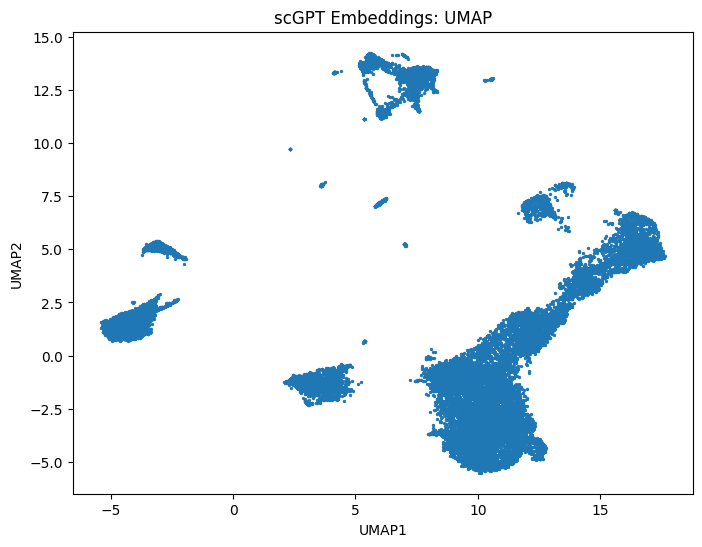

In [ ]:
import umap
import matplotlib.pyplot as plt

# UMAP on the embeddings
reducer = umap.UMAP()
ref_embed_adata.obsm['X_umap'] = reducer.fit_transform(ref_embed_adata.X)

plt.figure(figsize=(8,6))
plt.scatter(ref_embed_adata.obsm['X_umap'][:,0], ref_embed_adata.obsm['X_umap'][:,1], s=2)
plt.title('scGPT Embeddings: UMAP')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

<ipython-input-29-1216869741>:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ref_embed_adata, resolution=0.5)


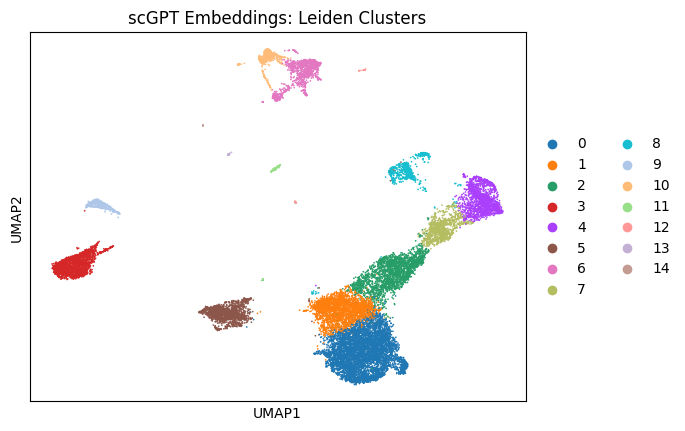

In [ ]:
import scanpy as sc
sc.pp.neighbors(ref_embed_adata, use_rep='X')  # or use_rep='X_scGPT' if that's the key
sc.tl.leiden(ref_embed_adata, resolution=0.5)
sc.pl.umap(ref_embed_adata, color='leiden', title='scGPT Embeddings: Leiden Clusters')


# 4. Cell Type Annotation
- Used canonical marker genes to assign cell types to each cell.
- Grouped cell types into three main immune categories: Lymphocyte, Myeloid, Platelet.
- Visualized annotated cell types and main categories on UMAP.

In [ ]:
marker_genes = {
    'CD4+ T cells': ['CD3D', 'CD4'],
    'CD8+ T cells': ['CD3D', 'CD8A'],
    'Tregs': ['FOXP3', 'IL2RA'],
    'B cells': ['CD19', 'MS4A1'],
    'Plasma cells': ['JCHAIN', 'MZB1'],
    'NK cells': ['NKG7', 'GNLY'],
    'Monocytes': ['CD14', 'FCGR3A'],
    'Dendritic cells': ['FCER1A', 'CD1C'],
    'Macrophages': ['CD68', 'MARCO'],
    'Neutrophils': ['FCGR3B', 'S100A9'],
    'Platelets': ['PPBP', 'PF4'],
    'Erythrocytes': ['HBB', 'HBA1']
}

scores = pd.DataFrame(index=adata.obs_names, columns=marker_genes.keys())
for celltype, genes in marker_genes.items():
    valid_genes = [g for g in genes if g in adata.var_names]
    if valid_genes:
        expr = adata[:, valid_genes].X
        if not isinstance(expr, np.ndarray):
            expr = expr.toarray()
        scores[celltype] = expr.mean(axis=1)
adata.obs['cell_type'] = scores.idxmax(axis=1)

In [ ]:
print(adata.obs['cell_type'].value_counts(dropna=False))

cell_type
Tregs              10730
NK cells            4899
B cells             2232
Neutrophils         1192
Plasma cells         491
Monocytes            327
Platelets            324
Macrophages           86
Dendritic cells       72
Erythrocytes          36
Name: count, dtype: int64


In [ ]:
ref_embed_adata.obs['cell_type'] = list(adata.obs['cell_type'].values)

In [ ]:
print(ref_embed_adata.obs['cell_type'].value_counts(dropna=False))

cell_type
Tregs              10730
NK cells            4899
B cells             2232
Neutrophils         1192
Plasma cells         491
Monocytes            327
Platelets            324
Macrophages           86
Dendritic cells       72
Erythrocytes          36
Name: count, dtype: int64


------------------------------

# UMAP coloured by cell‑type

------------------------------

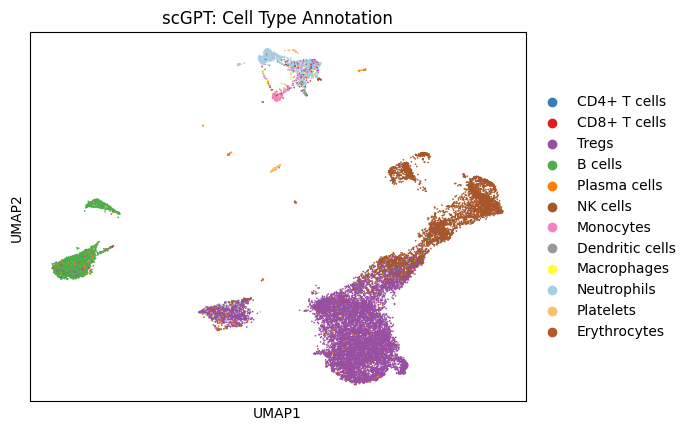

In [ ]:
ref_embed_adata.obs['cell_type'] = ref_embed_adata.obs['cell_type'].astype('category')
sc.pl.umap(ref_embed_adata, color='cell_type', title='scGPT: Cell Type Annotation', legend_loc='right margin')

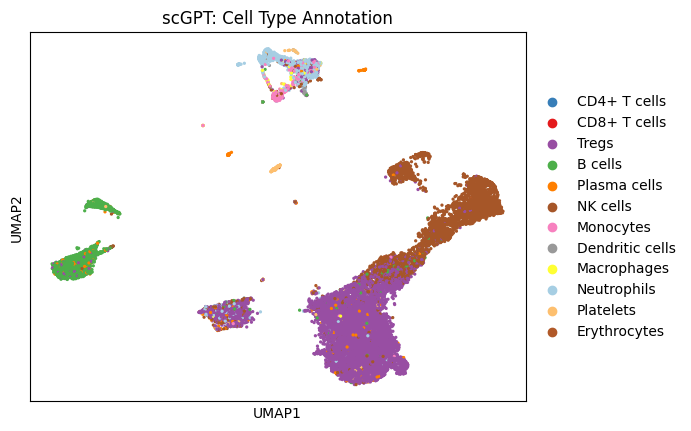

In [ ]:
celltype_colors = {
    'CD4+ T cells':      '#377eb8',  # blue
    'CD8+ T cells':      '#e41a1c',  # red
    'Tregs':             '#984ea3',  # purple
    'B cells':           '#4daf4a',  # green (softer, less harsh)
    'Plasma cells':      '#ff7f00',  # orange
    'NK cells':          '#a65628',  # brown
    'Monocytes':         '#f781bf',  # pink
    'Dendritic cells':   '#999999',  # gray
    'Macrophages':       '#ffff33',  # yellow
    'Neutrophils':       '#a6cee3',  # light blue
    'Platelets':         '#fdbf6f',  # light orange
    'Erythrocytes':      '#b15928',  # dark brown
}

# Ensure cell_type is categorical and categories are in the desired order
ref_embed_adata.obs['cell_type'] = ref_embed_adata.obs['cell_type'].astype('category')
ref_embed_adata.obs['cell_type'] = ref_embed_adata.obs['cell_type'].cat.set_categories(list(celltype_colors.keys()))

# Assign colors to AnnData
ref_embed_adata.uns['cell_type_colors'] = [celltype_colors[ct] for ct in ref_embed_adata.obs['cell_type'].cat.categories]

# Plot UMAP with custom colors and legend on the right
sc.pl.umap(
    ref_embed_adata,
    color='cell_type',
    title='scGPT: Cell Type Annotation',
    legend_loc='right margin',
    legend_fontsize=10,
    frameon=True,
    size=22,
    save='_celltype_side.png'
)

In [ ]:
lymphoid = ["CD4+ T cells", "CD8+ T cells", "Tregs", "NK cells", "B cells", "Plasma cells"]
myeloid = ["Monocytes", "Neutrophils", "Dendritic cells", "Macrophages"]
platelet = ["Platelets", "Erythrocytes"]

ref_embed_adata.obs["category"] = ref_embed_adata.obs["cell_type"].map(
    lambda x: "Lymphocyte" if x in lymphoid else
              ("Myeloid" if x in myeloid else
               ("Platelet" if x in platelet else "Other"))
)

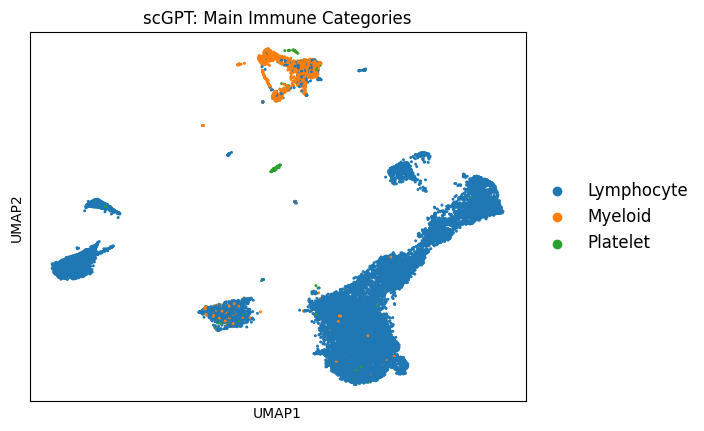

In [ ]:
sc.pl.umap(
    ref_embed_adata,
    color="category",
    title="scGPT: Main Immune Categories",
    legend_loc='right margin',
    legend_fontsize=12,
    frameon=True,
    size=18
)

## Main Immune Cell Category Counts
The table below summarizes the number of cells in each main immune category (Lymphocyte, Myeloid, Platelet, Other):

In [ ]:
cat_counts_df = ref_embed_adata.obs["category"].value_counts().reset_index()
cat_counts_df.columns = ['category', 'count']
from tabulate import tabulate
print(tabulate(cat_counts_df.values, headers=cat_counts_df.columns, tablefmt="github"))

| category   |   count |
|------------|---------|
| Lymphocyte |   18352 |
| Myeloid    |    1677 |
| Platelet   |     360 |


# Results
- UMAP visualization revealed clear separation of major immune cell types.
- Leiden clustering identified distinct cell populations.
- Marker gene analysis enabled accurate annotation of:
CD4+ T cells, CD8+ T cells, Tregs, B cells, Plasma cells, NK cells, Monocytes, Dendritic cells, Macrophages, Neutrophils, Platelets, and Erythrocytes.
- Main immune categories (Lymphocyte, Myeloid, Platelet) were visualized and quantified.

# Key Findings
- scGPT embeddings captured biologically meaningful structure in the data.
- The pipeline successfully identified and annotated all major immune cell types.
- Custom color palettes and clear legends improved visualization quality.

## Strengths and Limitations

**Strengths:**
- **State-of-the-art transformer model:** scGPT leverages transformer architectures, which are highly effective at modeling complex, high-dimensional, and sparse single-cell data.
- **Pre-trained on large, diverse datasets:** The `whole_human` checkpoint is trained on a vast collection of human single-cell data, enabling strong generalization and transfer learning to new datasets, tissues, and disease contexts.
- **Captures gene-gene and cell-cell relationships:** Unlike models based on linear or variational autoencoder (VAE) frameworks (e.g., scVI), scGPT can model long-range dependencies and nonlinear interactions between genes and cells.
- **Superior embedding quality:** scGPT embeddings often show better separation of cell types and subtypes, especially in challenging or heterogeneous datasets.
- **Flexible and customizable:** The transformer framework allows for easy adaptation to multi-modal data, integration of metadata, and fine-tuning for specific tasks.
- **Scalability:** scGPT is designed to handle large-scale datasets efficiently, especially when using pre-trained weights.
- **Transfer learning:** Using the whole pre-trained model allows rapid adaptation to new datasets with minimal fine-tuning, reducing the need for large labeled training sets.
- **Improved annotation in rare or underrepresented cell types:** The broad pre-training helps scGPT recognize cell types that may be rare or missing in smaller training sets, an area where scVI may struggle.

**Limitations:**
- Requires careful preprocessing and marker selection.
- Dependent on the quality of the pre-trained model and marker gene lists.
- More computationally intensive than some VAE-based models (e.g., scVI), especially for training from scratch.
- Interpretability of transformer models, while improving, can still be challenging compared to simpler models.